In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-31_09-50_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.06755001299038711

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
GC       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    23296.5
GC    14917.8
NQ    33429.2
YM    27042.0
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

98685.5

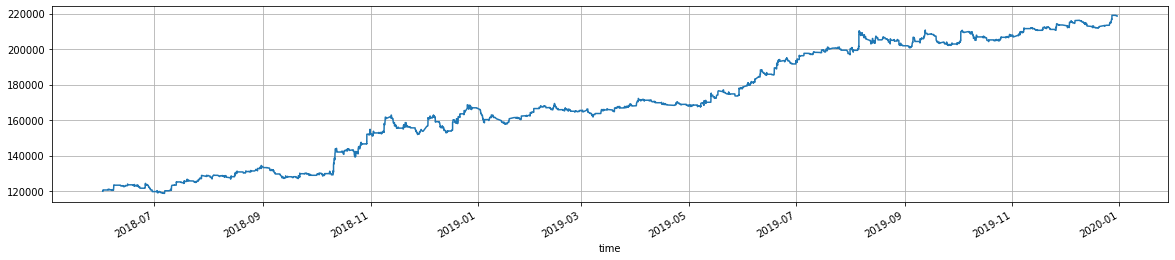

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     461
 GC     910
 NQ    1948
 YM     530
 Name: action, dtype: int64,
 3849)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.118932
 GC    2.208738
 NQ    4.728155
 YM    1.286408
 Name: action, dtype: float64,
 9.342233009708737)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     968.1
GC    2202.2
NQ    4090.8
YM    1113.0
Name: commission, dtype: float64

In [16]:
df.commission.sum()

8374.100000000002

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,32.79,479.78,-265.21,1.81,32.79,455.0
NQ,0.40,34.32,456.13,-249.78,1.83,32.58,974.0
YM,0.42,102.05,760.35,-372.45,2.04,103.33,265.0
ES,0.40,101.29,1022.45,-501.77,2.04,107.92,230.0
total,0.40,51.29,571.60,-300.42,1.90,48.39,1924.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.013295,0.171913,0.391271,0.683246
GC,-0.013295,1.000000,0.077023,0.044768,0.380219
NQ,0.171913,0.077023,1.000000,0.195561,0.642086
YM,0.391271,0.044768,0.195561,1.000000,0.676731
total,0.683246,0.380219,0.642086,0.676731,1.000000


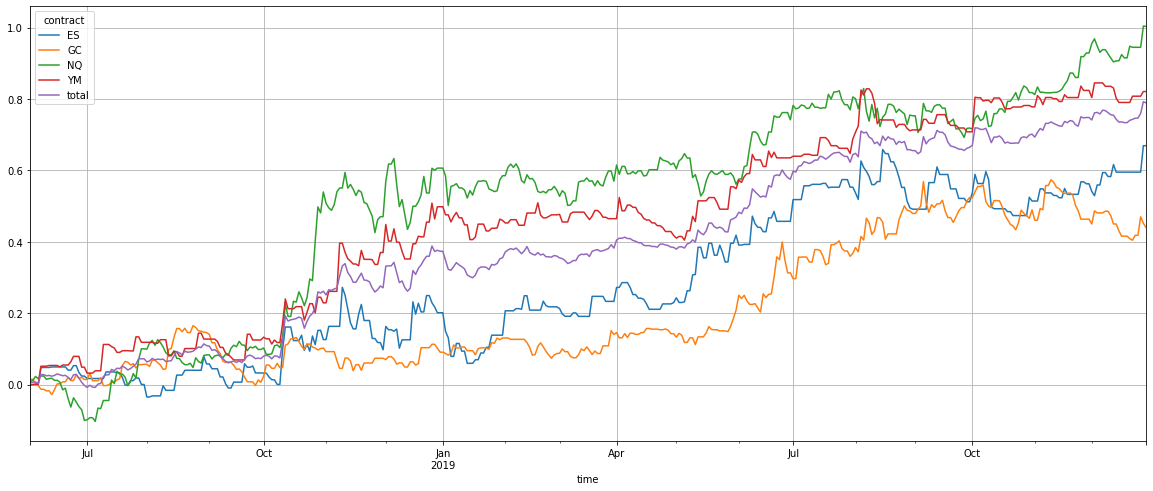

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

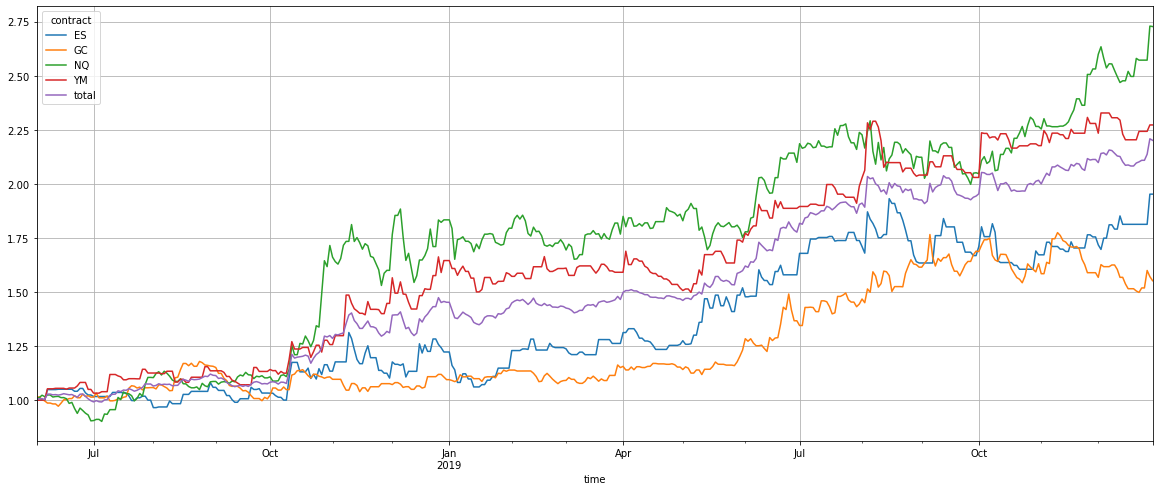

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.505647,0.308613,0.847093,0.652050,0.620240
Cumulative returns,0.952375,0.552306,1.727018,1.272221,1.201129
Annual volatility,0.366983,0.266773,0.369754,0.317815,0.201829
Sharpe ratio,1.294274,1.140107,1.843297,1.734786,2.492248
Calmar ratio,2.638306,1.981386,4.703059,5.745108,7.293754
Stability,0.895620,0.812002,0.871192,0.950551,0.965504
Max drawdown,-0.191656,-0.155756,-0.180115,-0.113497,-0.085037
Omega ratio,1.371553,1.255853,1.428202,1.558710,1.647532
Sortino ratio,2.530634,2.038805,3.221057,3.747962,5.258711
Skew,1.718392,1.128276,0.869158,2.346668,1.872521


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.40,1.43,-9.55,4.99,-0.24
2018-07-31,-2.33,4.34,22.20,7.21,7.75
2018-08-31,5.93,9.30,-1.69,0.91,3.75
2018-09-30,-2.49,-12.99,1.52,-0.26,-3.58
2018-10-31,9.79,10.05,55.46,10.96,20.80
2018-11-30,-2.82,-2.81,-6.70,15.14,0.97
2018-12-31,10.95,1.72,14.58,13.68,10.76
2019-01-31,-6.10,4.05,-2.11,-3.75,-1.79
2019-02-28,8.26,-4.28,-3.95,1.58,0.45


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        95.0
GC        55.0
NQ       173.0
YM       127.0
total    120.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 16:26:00,YM,SELL,26156.00,5000.8
2018-11-09 09:08:00,ES,SELL,2796.25,4233.3
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
2018-12-17 16:04:30,ES,BUY,2579.25,3370.8
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2019-10-10 22:34:00,ES,BUY,2953.50,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.043839,0.035793,0.106360,0.074901
2018-10-11,0.064440,0.064183,0.098133,0.070107,0.074216
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
2018-12-17,0.112360,0.000000,0.046440,0.043580,0.050595
2019-10-02,0.053610,0.017355,0.029633,0.101693,0.050573
...,...,...,...,...,...
2018-11-13,-0.038890,0.000011,-0.043200,-0.017613,-0.024923
2019-01-03,-0.017363,-0.004828,-0.079340,0.000000,-0.025383
2018-10-22,-0.041530,-0.009161,-0.021920,-0.037113,-0.027431
